In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
Ts = 1/12
c = 20
eta = 0.9

case_template = 'Strategic/LDES/10GW_ED1_Strategic_true_FORB_true_ratio1.0_Seg5_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
# LDES100 = [2.23,1.796,1.115,0.599,0.0]

### Price Stats

In [53]:
# Initialize lists to hold DataFrames
mean_prices_dfs = []
std_prices_dfs = []

In [54]:
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for (ratio,LDES) in zip(ratios,LDES24):
    case = case_template.format(ratio, LDES)
    try:
        # Try to read the CSV file for the current case
        price = pd.read_csv('output/'+case+'/EDprice.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

    # Calculate stats and transpose
    pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

    # Now, instead of appending Series objects, you create DataFrame slices for each and append them
    mean_prices_dfs.append(pricestats.iloc[[0]])
    std_prices_dfs.append(pricestats.iloc[[1]])

In [55]:
# Convert lists of series to DataFrames
mean_prices_df = pd.concat(mean_prices_dfs).reset_index(drop=True)
std_prices_df = pd.concat(std_prices_dfs).reset_index(drop=True)
mean_prices_df.index = ratios
std_prices_df.index = ratios

In [56]:
mean_prices_df

,0,1,2,3,4,5
0.00,53.227410,69.876276,51.937453,7.424033,49.262541,53.192782
0.25,53.151698,69.878504,52.039149,7.334076,49.168267,53.100663
0.50,53.138293,69.697519,51.250875,7.162664,49.194771,52.764527
0.75,53.003305,68.162366,49.182557,6.980854,49.393228,51.770235
1.00,52.172718,65.855010,46.973196,6.479887,48.914329,49.816793


In [57]:
std_prices_df

,0,1,2,3,4,5
0.00,17.784523,24.282672,18.781927,53.461438,18.988074,18.160352
0.25,17.907705,24.073136,18.901950,53.431568,19.163576,18.258641
0.50,18.233930,24.226901,18.716304,53.430869,19.411219,18.566267
0.75,19.330182,24.903230,19.287606,53.449147,20.117127,19.321341
1.00,21.746196,33.262279,22.629248,53.268220,21.081207,22.790143


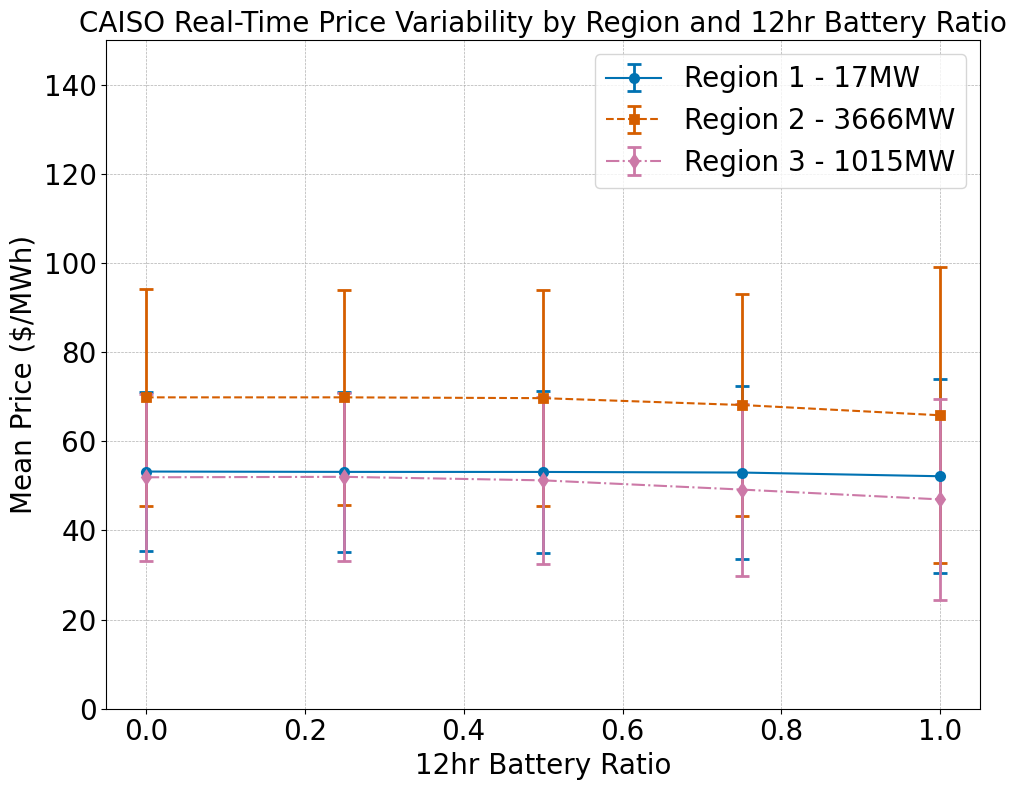

In [58]:
# Assuming mean_prices_df and std_prices_df are already defined
# Selecting the columns for Regions 1, 2, and 3
regions = [0, 1, 2]
mean_prices = mean_prices_df.iloc[:, regions]
std_prices = std_prices_df.iloc[:, regions]

# Preparing ISR values from the index
isr_values = mean_prices.index

# New colors and error bar theme
new_colors = ['#0072B2', '#D55E00', '#CC79A7']  # Updated color palette
new_labels = ['Region 1 - 17MW', 'Region 2 - 3666MW', 'Region 3 - 1015MW']
line_styles = ['-', '--', '-.']  # Different line styles for visual distinction
marker_styles = ['o', 's', 'd']  # Different marker styles for each region
plt.figure(figsize=(10, 8))

for region, color, label, line_style, marker_style in zip(regions, new_colors, new_labels, line_styles, marker_styles):
    plt.errorbar(isr_values, mean_prices.iloc[:, region], yerr=std_prices.iloc[:, region], 
                 label=label, color=color, fmt=line_style + marker_style, capsize=5, elinewidth=2, capthick=2, markeredgewidth=2)

plt.title('CAISO Real-Time Price Variability by Region and 12hr Battery Ratio', fontsize=20)
plt.xlabel('12hr Battery Ratio', fontsize=20)
plt.ylabel('Mean Price ($/MWh)', fontsize=20)
plt.ylim([0, 150])
plt.legend(fontsize=20, loc = 'upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Setting tick parameters for both axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()

# Save the plot to a file suitable for inclusion in your paper
# plt.savefig('/mnt/data/caiso_price_variability.png', dpi=300)

# Show the plot
plt.show()

### Total System Cost & Avg SOC

In [31]:
case_template = 'Strategic/LDES/10GW_ED1_Strategic_true_FORB_true_ratio1.0_Seg1_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
# LDES100 = [2.23,1.796,1.115,0.599,0.0]
# ratios = [0.0]
# LDES100 = [2.23]
# ratios = [1.0]
# LDES100 = [0.0]
# Capacity = 39930.144
# Capacity = 59895.216
# Capacity = 79860.288

total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for (ratio,LDES) in zip(ratios,LDES24):
    case = case_template.format(ratio, LDES)
    Capacity = (ratio+1)*10000*4 + LDES*10000*24

    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue
#     CapacityM = Capacity*ratio*3 + Capacity*(1-ratio)
    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df.index = ratios


total_system_costs_df

,Total System Cost,Average System SoC
0.00,1.365660,52.177129
0.25,1.365310,51.518219
0.50,1.364243,52.861334
0.75,1.361103,49.514201
1.00,1.358679,26.348494


In [32]:
case_template = 'Strategic/LDES/10GW_ED1_Strategic_true_FORB_true_ratio1.0_Seg5_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
LDES100 = [2.23,1.796,1.115,0.599,0.0]
# ratios = [0.0]
# LDES100 = [2.23]
# ratios = [1.0]
# LDES100 = [0.0]
# Capacity = 39930.144
# Capacity = 59895.216
# Capacity = 79860.288

total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for (ratio,LDES) in zip(ratios,LDES24):
    case = case_template.format(ratio, LDES)
    Capacity = (ratio+1)*10000*4 + LDES*10000*24

    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
        SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append({
                'System Cost': float('nan'),
                'Average SoC': float('nan')
        })
        continue
#     CapacityM = Capacity*ratio*3 + Capacity*(1-ratio)
    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    if ratio == 0.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_ai = float('nan')
    elif ratio == 1.0:
        avg_soc = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = float('nan')
#         avg_soc_ai = SOC.iloc[:, -6:].sum().sum()/(Capacity*288*364)*100
    else:
        avg_soc = SOC.iloc[:, -12:].sum().sum()/(Capacity*288*364)*100
#         avg_soc_bs = SOC.iloc[:, -11::2].sum().sum()/(Capacity*288*364*(1-ratio))*100
#         avg_soc_ai = SOC.iloc[:, -12::2].sum().sum()/(Capacity*288*364*ratio)*100
    total_system_costs.append({
                'Total System Cost': total_cost_normalized,
                'Average System SoC': avg_soc,
#                 'Average BS-ES SoC': avg_soc_bs,
#                 'Average AI-ES SoC': avg_soc_ai,       
        })
# Convert the list to a DataFrame
total_system_costs_df2 = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average System SoC'])
# total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost','Average BS-ES SoC','Average AI-ES SoC'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df2.index = ratios


total_system_costs_df2

,Total System Cost,Average System SoC
0.00,1.362544,50.928696
0.25,1.362087,49.804464
0.50,1.361214,47.901949
0.75,1.358024,44.354175
1.00,1.355304,24.866868


In [ ]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg5_BAW0_BSESCbid0.5_LDESRatio_{}-0.0-0.0-{}_LDESDur_4-10-24-100_LDESEta_0.9-0.75-0.75-0.75'
# ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
# LDES100 = [2.23,1.796,1.115,0.599,0.0]
ratios = [0.0]
LDES100 = [2.23]
cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
SOC = pd.read_csv(f'output/{case}/EDSOCini.csv', header=None)
char = pd.read_csv(f'output/{case}/EDESChaZone.csv', header=None)
disc = pd.read_csv(f'output/{case}/EDESDisZone.csv', header=None)
price = pd.read_csv(f'output/{case}/EDprice.csv', header=None)

In [ ]:
cost_df = cost.groupby('group').sum()[288:384]
cost_df

In [ ]:
# Summing every 12 rows
cost['group'] = cost.index // 12
cost_df = cost.groupby('group').sum()[288:384]
char['group'] = char.index // 12
char_df = char.groupby('group').sum().sum(axis=1)[288:384]
disc['group'] = disc.index // 12
disc_df = disc.groupby('group').sum().sum(axis=1)[288:384]
netchar_df = char_df-disc_df

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(cost_df, color='b', label='Cost')
ax1.set_xlabel('Group')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a second y-axis
ax2 = ax1.twinx()
ax2.plot(char_df, color='g', label='Char')
ax2.plot(disc_df, color='r', label='Disc')
ax2.plot(netchar_df, color='black', label='NetChar')

# ax2.set_ylabel('Char', color='g')
# ax2.tick_params(axis='y', labelcolor='g')

# Adding title and legends
plt.title('Line Plot of Summed Data with Dual Y-Axis')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
price['group'] = price.index // 12
price_df = price.groupby('group').sum()[288:384]
# Plotting
plt.figure(figsize=(12, 6))

for column in price_df.columns:
    plt.plot(price_df[column], label=column)

plt.xlabel('Group')
plt.ylabel('Sum of every 12 rows')
plt.title('Line Plot of Price Data')
plt.legend()
plt.show()

In [ ]:
char['group'] = char.index // 12
char_df = char.groupby('group').sum()[288:384]
disc['group'] = disc.index // 12
disc_df = disc.groupby('group').sum()[288:384]
netchar_df = char_df-disc_df
# Plotting
plt.figure(figsize=(12, 6))

for column in netchar_df.columns:
    plt.plot(netchar_df[column], label=column)

plt.xlabel('Group')
plt.ylabel('Sum of every 12 rows')
plt.title('Line Plot of Price Data')
plt.legend()
plt.show()

In [ ]:
summed_df2

In [ ]:
SOC['group'] = SOC.index // 12
summed_df2 = SOC.groupby('group').sum().sum(axis=1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(summed_df2[288:576])
plt.ylim([0, 3e7])
plt.xlabel('Group')
plt.ylabel('Sum of every 12 rows')
plt.title('Line Plot of Sum of Every 12 Rows')
plt.show()

In [ ]:
# Summing every 12 rows
cost['group'] = cost.index // 12
summed_df = cost.groupby('group').sum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(summed_df)
plt.xlabel('Group')
plt.ylabel('Sum of every 12 rows')
plt.title('Line Plot of Sum of Every 12 Rows')
plt.show()

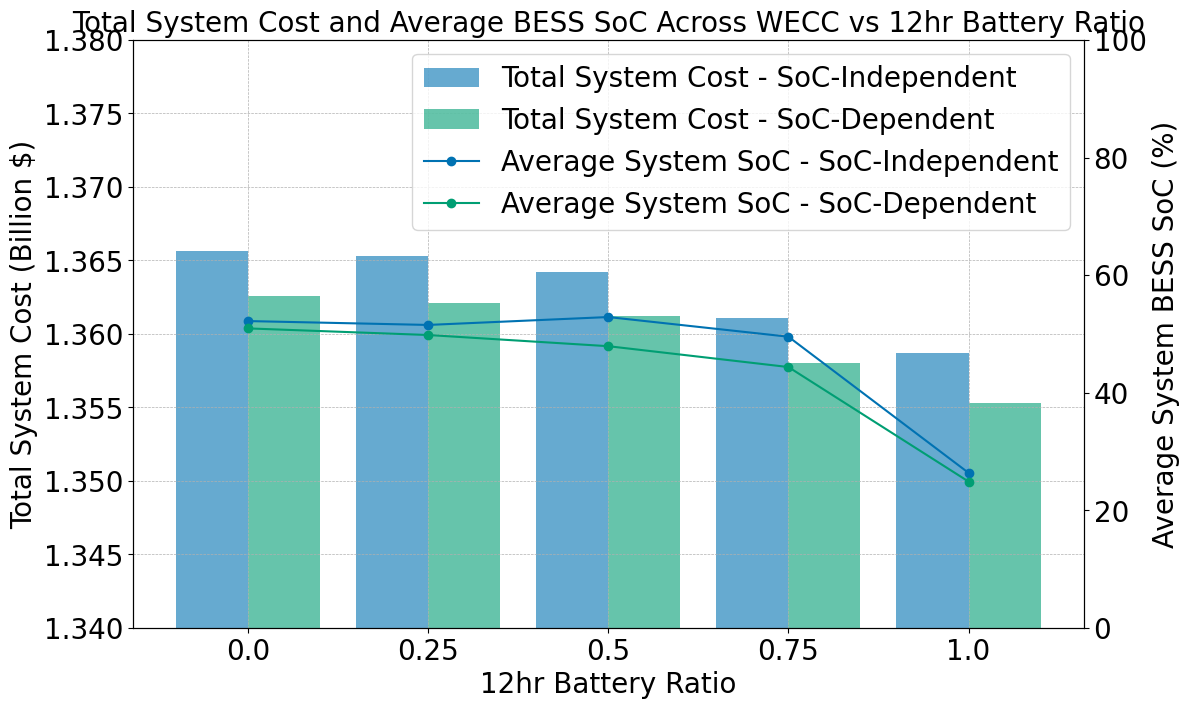

In [39]:
# Define ratios (x-axis values)
ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# Assuming total_system_costs_df and total_system_costs_df2 are already defined
# Calculate percentage reduction compared to 0.0 ISR
initial_cost1 = total_system_costs_df['Total System Cost'].iloc[0]
initial_cost2 = total_system_costs_df2['Total System Cost'].iloc[0]

percentage_reduction1 = (total_system_costs_df['Total System Cost'] - initial_cost1) / initial_cost1 * 100
percentage_reduction2 = (total_system_costs_df2['Total System Cost'] - initial_cost2) / initial_cost2 * 100

# Define bar width and bar positions
bar_width = 0.4
bar_positions1 = np.arange(len(ratios))
bar_positions2 = bar_positions1 + bar_width

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot total system costs
color1 = '#0072B2'
color2 = '#009E73'
ax1.set_xlabel('12hr Battery Ratio', fontsize=20)
ax1.set_ylabel('Total System Cost (Billion $)', fontsize=20)
bar1 = ax1.bar(bar_positions1, total_system_costs_df['Total System Cost'], width=bar_width, color=color1, alpha=0.6, label='Total System Cost - SoC-Independent')
bar2 = ax1.bar(bar_positions2, total_system_costs_df2['Total System Cost'], width=bar_width, color=color2, alpha=0.6, label='Total System Cost - SoC-Dependent')
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim([1.34, 1.38])

# Instantiate a second y-axis for percentage reduction
ax2 = ax1.twinx()
ax2.set_ylabel('Average System BESS SoC (%)', fontsize=20)

# Plot percentage reductions
line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average System SoC'], '-o', color=color1, label='Average System SoC - SoC-Independent')
line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average System SoC'], '-o', color=color2, label='Average System SoC - SoC-Dependent')
# line1, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average BS-ES SoC'], '-o', color=color1, label='Average BS-ES SoC - SoC-Independent')
# line2, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average BS-ES SoC'], '-o', color=color2, label='Average BS-ES SoC - SoC-Dependent')
# line3, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df['Average AI-ES SoC'], '-s', color=color1, label='Average AI-ES SoC - SoC-Independent')
# line4, = ax2.plot(bar_positions1 + bar_width / 2, total_system_costs_df2['Average AI-ES SoC'], '-s', color=color2, label='Average AI-ES SoC - SoC-Dependent')
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim([0,100])

# Set x-axis ticks to be in the middle of the grouped bars
ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(ratios, fontsize=20)

# Combine legends from both axes
lines = [line1, line2]
# lines = [line1, line2, line3, line4]
bars = [bar1, bar2]
ax1.legend(bars + lines, [bar.get_label() for bar in bars] + [line.get_label() for line in lines], loc='upper right', fontsize=20)

fig.tight_layout()
plt.title('Total System Cost and Average BESS SoC Across WECC vs 12hr Battery Ratio', fontsize=20)
plt.show()

### Loss of load

In [40]:
LL = pd.DataFrame(index=[0.0,0.25,0.5,0.75,1.0])

In [41]:
case_template = 'Strategic/LDES/10GW_ED1_Strategic_true_FORB_true_ratio1.0_Seg1_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
LDES100 = [2.23,1.796,1.115,0.599,0.0]

case_name = 'SOC-Independent'

In [44]:
case_template = 'Strategic/LDES/10GW_ED1_Strategic_true_FORB_true_ratio1.0_Seg5_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
LDES100 = [2.23,1.796,1.115,0.599,0.0]

case_name = 'SOC-Dependent'

In [45]:
total_system_ll = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for (ratio,LDES) in zip(ratios,LDES24):
    case = case_template.format(ratio, LDES)
    try:
        # Read the CSV file for the current case
        ll = pd.read_csv(f'output/{case}/EDSlack.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_ll.append(float('nan'))
        continue

    # Sum the total ll
    total_ll = ll.sum().sum()/12
    total_system_ll.append(total_ll)
total_system_ll  

[0.0, 0.0, 0.0, 21.963742427041126, 1585.4002995185404]

In [46]:
LL[case_name] = total_system_ll
LL

,SOC-Independent,SOC-Dependent
0.00,7385.548885,0.000000
0.25,6188.985810,0.000000
0.50,7774.072172,0.000000
0.75,5659.705762,21.963742
1.00,5216.239425,1585.400300


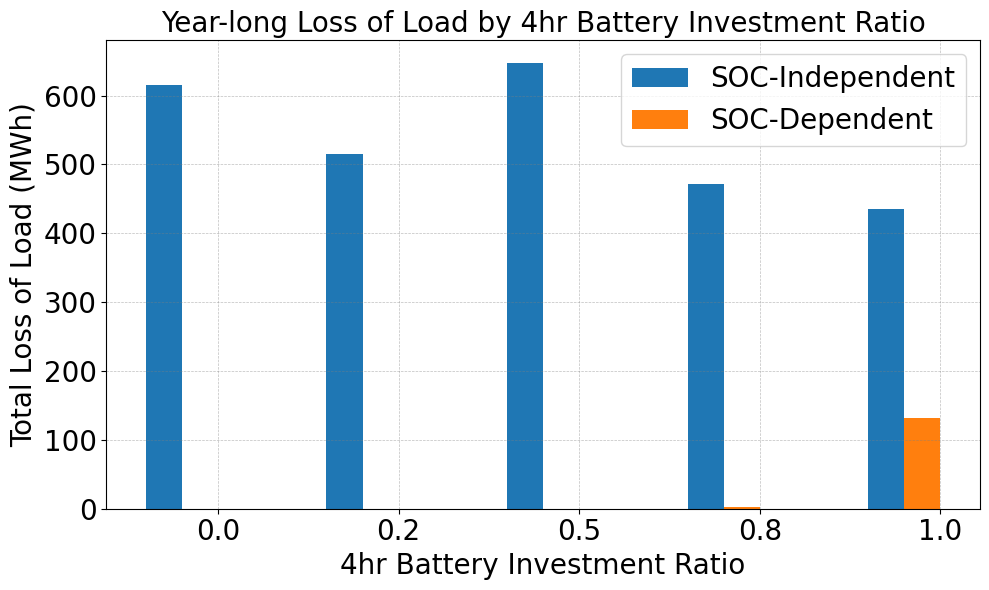

In [50]:
case_names = LL.columns
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(LL.index))  # the label locations
width = 0.2  # the width of the bars
fontsize = 20
# Define colors for related cases
colors = ['#1f77b4', '#ff7f0e', '#aec7e8', '#ffbb78']  # Dark and light shades of blue and orange

for i, name in enumerate(case_names):
    ax.bar(x + i*width - width*1.5, LL[name]/12, width, label=name, color=colors[i])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('4hr Battery Investment Ratio', fontsize=fontsize)
ax.set_ylabel('Total Loss of Load (MWh)', fontsize=fontsize)
ax.set_title('Year-long Loss of Load by 4hr Battery Investment Ratio', fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels([f"{label:.1f}" for label in LL.index], fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.legend(fontsize=fontsize, title_fontsize=fontsize)

# Beautify the plot
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()

plt.show()

## Storage Profit & Utilization (12hr Battery 0.1-0.5)

In [ ]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg5_BSESCbid0.5_LDESRatio_{}-0.0-{}-0.0'


ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
LDES24= [1.64, 1.23, 0.82, 0.41, 0.0]
LDES100 = [2.23,1.796,1.115,0.599,0.0]
# ratios = [0.0]
# LDES100 = [2.23]
region = 2

# Initialize an empty list to store results
results = []

# Initialize an empty list to store results
results = []

# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for (ratio,LDES) in zip(ratios,LDES24):
    case = case_template.format(ratio, LDES)
    try:
        # Try to read the CSV file for the current case
        ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
        ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
        price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
        ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
        ES = pd.read_csv('output/'+case+'/Strategic/ADDED_LDES.csv')
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue
    if (ratio <= 0.9) & (ratio >=0.1):
        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        BESSRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000 + sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 1]*price[i])/1000
        LDESRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 2]*price[i])/1000
        BESSProfit = BESSRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000 - sum(Ts*c*ESD[ESID-1].iloc[:, 1])/1000
        LDESProfit = LDESRevenue - sum(Ts*10*ESD[ESID-1].iloc[:, 2])/1000
        BESSUnitProfit = BESSProfit/(ES['EPD'][i+35]+ES['EPD'][2*i+41])
        LDESUnitProfit = LDESProfit/ES['EPD'][2*i+42]
        BESSCycle = sum(ESD[ESID-1].iloc[:, 0]+ESD[ESID-1].iloc[:, 1])/eta*Ts/(ES['ESOC'][i+35]+ES['EPD'][2*i+41])
        LDESCycle = sum(ESD[ESID-1].iloc[:, 2])/0.75*Ts/ES['ESOC'][2*i+42]
    elif ratio == 1.0:
        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        BESSRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000 + sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 1]*price[i])/1000
        LDESRevenue = 0.0
        BESSProfit = BESSRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000 - sum(Ts*c*ESD[ESID-1].iloc[:, 1])/1000
        LDESProfit = 0.0
        BESSUnitProfit = BESSProfit/(ES['EPD'][i+35]+ES['EPD'][i+41])
        LDESUnitProfit = 0.0
        BESSCycle = sum(ESD[ESID-1].iloc[:, 0]+ESD[ESID-1].iloc[:, 1])/eta*Ts/(ES['ESOC'][i+35]+ES['EPD'][i+41])
        LDESCycle = 0.0
    elif ratio == 0.0:
        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        BESSRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000
        LDESRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 1]*price[i])/1000
        BESSProfit = BESSRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000
        LDESProfit = LDESRevenue - sum(Ts*10*ESD[ESID-1].iloc[:, 1])/1000
        BESSUnitProfit = BESSProfit/ES['EPD'][i+35]
        LDESUnitProfit = LDESProfit/ES['EPD'][i+42]
        BESSCycle = sum(ESD[ESID-1].iloc[:, 0])/eta*Ts/(ES['ESOC'][i+35])
        LDESCycle = sum(ESD[ESID-1].iloc[:, 1])/0.75*Ts/ES['ESOC'][i+42]
        

    # Append results to list
    results.append({
        '4hr Ratio': ratio,
        '4hrRevenue': BESSRevenue,
        '100hrRevenue': LDESRevenue,
        '4hrProfit': BESSProfit,
        '100hrProfit': LDESProfit,
        '4hrUnitProfit': BESSUnitProfit,
        '100hrUnitProfit': LDESUnitProfit,
        '4hrCycle': BESSCycle,
        '100hrCycle': LDESCycle
    })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)
results_df


In [ ]:
# Define a color palette
colors = ['#FFA07A', '#4682B4', '#FFA07A', '#4682B4']

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

# Set bar width
bar_width = 0.4
index = range(len(results_df))

# Plotting bars for AIUnitProfit and BSUnitProfit
bar1 = ax1.bar([i - bar_width/2 for i in index], results_df['4hrUnitProfit'], bar_width, label='4hrUnitProfit (k$/MW)', color=colors[0])
bar2 = ax1.bar([i + bar_width/2 for i in index], results_df['100hrUnitProfit'], bar_width, label='100hrUnitProfit (k$/MW)', color=colors[1])

# Adding labels and title for the primary y-axis
ax1.set_xlabel('Ratio', fontsize=20)
ax1.set_ylabel('Unit Profit (k$/MW)', fontsize=20)
ax1.set_xticks(index)
ax1.set_xticklabels(results_df['4hr Ratio'], fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([-500, 300])


# Adding a secondary y-axis for AICycle and BSCycle
ax2 = ax1.twinx()
ax2.plot(index, results_df['4hrCycle'], label='4hrCycle', color=colors[2], linestyle='-', marker='o', linewidth=2)
ax2.plot(index, results_df['100hrCycle'], label='100hrCycle', color=colors[3], linestyle='-', marker='s', linewidth=2)
ax2.set_ylabel('Cycle', fontsize=20)
ax2.set_ylim(0, 400)
ax2.tick_params(axis='y', labelsize=20)

# Adding grid lines for better readability
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combining legends
bars_labels = [bar1, bar2]
lines_labels = [plt.Line2D([0], [0], color=colors[2], linestyle='-', marker='o', linewidth=2, label='AICycle'),
                plt.Line2D([0], [0], color=colors[3], linestyle='-', marker='s', linewidth=2, label='BSCycle')]

combined_legend = bars_labels + lines_labels
ax1.legend(handles=combined_legend, loc='upper right', fontsize=20)

# Adding title
plt.title('BESS Unit Profit and Cycle for Different 100hr Battery Ratios', fontsize=20)

# Improving layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
case_template = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_{}-{}_LDESDur_4-12'
ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
region = 2

# Initialize an empty list to store results
results = []

# Initialize an empty list to store results
results = []

# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    if (ratio <= 0.9) & (ratio >=0.1):
        case = case_template.format(round(1-ratio,1), ratio)
        try:
            # Try to read the CSV file for the current case
            ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
            ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
            price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
            ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
            ES = pd.read_csv('output/'+case+'/Strategic/UPDATED_LDES.csv')
        except FileNotFoundError:
            print(f"File for case {case} not found.")
            continue

        ESID = ESindex[ESindex['Region']==region]['StorageID']
        i = region -1
        AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1]).iloc[:, 0]*price[i])/1000
        BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
        AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1].iloc[:, 0])/1000
        BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
        AIUnitProfit = AIProfit/ES['EPD'][35+2*i+35]
        BSUnitProfit = BSProfit/ES['EPD'][2*i+36]
        AICycle = sum(ESD[ESID-1].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i]
        BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
        
        # Append results to list
        results.append({
            '12 hr Ratio': ratio,
            '4hrRevenue': AIRevenue,
            '12hrRevenue': BSRevenue,
            '4hrProfit': AIProfit,
            '12hrProfit': BSProfit,
            '4hrUnitProfit': AIUnitProfit,
            '12hrUnitProfit': BSUnitProfit,
            '4hrCycle': AICycle,
            '12hrCycle': BSCycle
        })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results)
results_df


In [ ]:
# case = 'Strategic/Exp1.2/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_1.0-2.0-2.0-2.0-2.0'
# case = 'Strategic/Quad/2022/ED1_Strategic_true_FORB_true_ratio0.0_Seg1_BAW0_BSESCbid0.5'
case = 'Strategic/LDES/ED1_Strategic_true_FORB_true_ratio1.0_Seg1_BAW0_BSESCbid0.5_LDESRatio_1.0-0.0_LDESDur_4-12'

ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
ESindex = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Storage_C_4hr_5GW_Strategic_Agg.csv')

In [ ]:
ESC[ESID-1].max()

In [ ]:
i = 1
region = i+1
ESID = region+35
AIRevenue = sum((ESD[ESID-1]-ESC[ESID-1])*price[i])/1000
# BSRevenue = sum((ESD[ESID]-ESC[ESID]).iloc[:, 0]*price[i])/1000
AIProfit = AIRevenue - sum(Ts*c*ESD[ESID-1])/1000
# BSProfit = BSRevenue - sum(Ts*c*ESD[ESID].iloc[:, 0])/1000
AIUnitProfit = AIProfit/ES['MaxCap(MWh)'][ESID-1]
# BSUnitProfit = BSProfit/ES['ESOC'][2*i+1]
AICycle = sum(ESD[ESID-1])/eta*Ts/ES['MaxCap(MWh)'][ESID-1]
# BSCycle = sum(ESD[ESID].iloc[:, 0])/eta*Ts/ES['ESOC'][2*i+1]
# print(AIRevenue,BSRevenue, AIProfit, BSProfit, AIUnitProfit, BSUnitProfit, AICycle, BSCycle)
print(AIRevenue, AIProfit, AIUnitProfit, AICycle)